# 学習型GaBP

## 必要なパッケージのインポート

In [3]:
import torch
import math
import time
import numpy as np
from scipy import linalg
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## グローバル定数の設定

In [4]:
M_   = 24   # 送信アンテナ数
N_   = 32   # 受信アンテナ数
K    = 10   # ミニバッチサイズ
rho  = 4    # 相関（0.1 x rho）
ml   = 4    # 変調レベル  
wloop= 2    # 試行回数 (10**wloop)
EsN0 = 4    # Es/N0 [dB]
Niter= 32   # GaBPの反復回数
adam_lr = 0.005 # Adamの学習率

## QAM変調クラス

In [10]:
class MOD():
    def __init__(self, ml):
        self.ml = ml
        self.nsym = 2 ** ml
        self.rep_b = np.empty((ml, self.nsym), int)
        for idx in range(0, self.nsym):
            for idx_ in range(0, ml):
                self.rep_b[idx_, idx] = (idx >> (self.ml - idx_ - 1)) % 2
        self.w = 2 ** np.arange(ml / 2)[::-1]
        self.w = np.concatenate([self.w, 1j * self.w], axis=0)
        self.val = np.dot(self.w, 2 * self.rep_b - 1)
        self.norm = np.sqrt(3 / (2 * (self.nsym - 1)))
        self.val *= self.norm
        self.Esmax = np.max(np.abs(self.val) ** 2)
        self.lv = 2 ** np.arange(ml)[::-1]
        self.lay = np.arange(ml -1,dtype=float)
        self.lay -= self.lay[-1] / 2
        self.lay *= 2*self.norm
        self.amap  = np.array([ 3, 2, 0, 1, 7, 6, 4, 5,15, 9,12,13,11,10, 8, 9],dtype=int)
        self.amap_ = np.array([ 2, 3, 1, 0, 6, 7, 5, 4,14,15,13,12,10,11, 9, 8],dtype=int)

           
    def demodulation(self, y):
        b_ = np.empty((y.shape[0], self.ml * y.shape[1]), int)
        b_tmp = np.empty((y.shape[1], self.ml), int)
        for idx_k in range(0, y.shape[0]):
            a_ = np.argmin(np.abs(y[idx_k, :] - np.tile(self.val, (y.shape[1], 1)).T) ** 2, axis=0)
            for idx_m in range(0, y.shape[1]):
                b_tmp[idx_m, :] = self.rep_b[:, self.amap_[a_[idx_m]]]
            b_[idx_k, :] = b_tmp.T.reshape(-1)
        return b_

    def llrcal(self, y, HH, N0):
        omega = torch.sum(HH, axis=1)
        llr_ = np.zeros((self.ml, y.shape[0]))
        met = -np.abs(y - np.tile(self.val, (y.shape[0], 1)).transpose()) ** 2/(N0/(omega[:y.shape[0]]+omega[y.shape[0]:]))
        for idx_l in range(0, self.ml):
            for idx_m in range(0, y.shape[0]):
                llr_[idx_l, idx_m]  = self.lnsumexp(met[self.rep_b[idx_l] == 1, idx_m])
                llr_[idx_l, idx_m] -= self.lnsumexp(met[self.rep_b[idx_l] == 0, idx_m])
        return llr_

    def lnsumexp(self, indata):
        leng = len( indata )
        tmp = indata[0]
        for idx in range(1, leng):
            corr_fac = torch.log(1.0 + torch.exp(-abs(tmp - indata[idx])))
            if (indata[idx] > tmp):
                tmp = indata[idx]
            tmp += corr_fac;
        return tmp

## 通信路クラス

In [11]:
class CH():
    def __init__(self, M_, N_, K, rho):
        self.M_ = M_
        self.N_ = N_
        self.K = K
        self.rho = rho

    def fading_gen(self):
        self.H = (np.random.randn(self.N_,self.M_) + 1j* np.random.randn(self.N_,self.M_))/np.sqrt(2)
        R = np.zeros((self.N_,self.N_))
        temp = (self.rho * 0.1) ** np.arange(0, self.N_)
        if (self.rho>0):
            for idx in range(0, self.N_):
                R[idx,:] = np.roll(temp,idx)
            L = linalg.cholesky(R)
            self.H = np.dot(L.T,self.H)

    def awgn_gen(self, N0):
        self.z = (np.random.randn(self.N_,self.K) + 1j* np.random.randn(self.N_,self.K))*np.sqrt(N0/2)

## ミニバッチ生成関数

In [12]:
def gen_minibatch(ch, mod, N0):
    # Source bits / alphabet / symbol
    b = np.random.randint(0, 2, (ch.M_ * mod.ml, ch.K))
    a = np.dot(np.kron(mod.lv, np.eye(ch.M_, dtype=int)), b)
    # TX symbol
    x = np.array(mod.val[mod.amap[a]])
    # Channel
    ch.awgn_gen(N0)
    y = np.dot(ch.H, x)  + ch.z

    xx = torch.from_numpy(np.concatenate([x.real, x.imag])).transpose(0, 1)
    yy = torch.from_numpy(np.concatenate([y.real, y.imag])).transpose(0, 1)

    H1 = np.concatenate([ch.H.real, -ch.H.imag], axis=1)
    H2 = np.concatenate([ch.H.imag, ch.H.real], axis=1)
    HH = torch.from_numpy(np.concatenate([H1, H2], axis=0))

    return b.T, xx.float(), yy.float(), HH.float()

## 学習可能なGaBP クラス

In [13]:
class TGaBP(nn.Module):
    def __init__(self, M, N, mod, Niter):
        super(TGaBP, self).__init__()
        v=4
        temp = -0.5 * np.ones(N)
        for idx in range(0, int(N/v)):
            temp[idx*v]=0.5

        temp_ = np.zeros((N,Niter))
        for idx in range(0, Niter):
            temp_[:,idx] = np.roll(temp,idx)
        self.eta = nn.Parameter(torch.from_numpy(temp_))
        self.mu = nn.Parameter(torch.from_numpy(2*(np.arange(0,Niter,1)+1)/Niter))

        self.M = M
        self.N = N
        self.mod = mod

    def sigmoid(self,eta):
        return 1/(1 + torch.exp(-4.0*eta))

    def SC(self, y, H, SR_mat, ER_mat):  # Soft Canceller
        # SC
        Reconstruct_matrix = H.T * SR_mat
        y_tilde = y - torch.sum(Reconstruct_matrix, axis=0) + Reconstruct_matrix
        delta = ER_mat - SR_mat ** 2
        return y_tilde, delta

    def BG(self, H, HH, N0, y_tilde, delta, uu, vv, eta,x):  # BG
        element = HH * delta

        psi = (torch.sum(element, axis=0).reshape(1, -1) - element) + N0 / 2.0
        #psi = 1.0

        u = H.T * y_tilde / psi
        uu = self.sigmoid(eta) * u + (1 - self.sigmoid(eta)) * uu

        s = (torch.sum(uu, axis=1) - uu.transpose(0, 1)).transpose(0, 1)
        v = HH / psi
        vv = self.sigmoid(eta) * v + (1 - self.sigmoid(eta)) * vv

        omega = (torch.sum(vv, axis=1) - vv.transpose(0, 1)).transpose(0, 1)
        gamma = s / omega
        gamma_post = torch.sum(u, axis=1) / torch.sum(v, axis=1)
        return gamma, gamma_post, uu, vv

    def RG(self, gamma, mu):  # RG
        SR_mat = torch.zeros((self.M, self.N))
        ER_mat = torch.zeros((self.M, self.N))
        for gamma_ in self.mod.lay:
            temp = mu * (gamma - gamma_) / self.mod.norm
            SR_mat += torch.tanh(temp)
            ER_mat += gamma_ * torch.tanh(temp)
        SR_mat *= self.mod.norm
        ER_mat *= 2 * self.mod.norm
        ER_mat += self.mod.Esmax / 2
        return SR_mat, ER_mat

    def SD(self, gamma_post, mu):  # RG
        SD_mat = torch.zeros(self.M)
        for gamma_ in self.mod.lay:
            temp =  mu*(gamma_post - gamma_) / self.mod.norm
            SD_mat += torch.tanh(temp)
        SD_mat *= self.mod.norm
        return SD_mat

    def forward(self, x, y, H, N0, mod, Niter=16):
        M_ = int(self.M / 2)
        K, N = y.shape
        HH = (H * H).T

        x_ = torch.zeros((K, self.M))
        x_hat = torch.zeros((K, self.M))
        llr_ = np.zeros((K, M_*mod.ml))

        for idx_sym in range(0, K):
            SR_mat = torch.zeros((self.M, self.N)).float()
            ER_mat = torch.ones((self.M, self.N)).float() / 2.0

            # # Perfect priori
            # SR_mat = np.tile(x[idx_sym, :], (N, 1)).T
            # ER_mat = SR_mat ** 2

            uu = torch.zeros((self.M, self.N))
            vv = torch.zeros((self.M, self.N))
            for idx_iter in range(0, Niter):
                # SC
                y_tilde, delta = TGaBP.SC(self, y[idx_sym, :], H, SR_mat, ER_mat)
                # BG
                gamma, gamma_post, uu, vv = TGaBP.BG(self, H, HH, N0, y_tilde, delta, uu, vv, self.eta[:, idx_iter],x[idx_sym,:])
                # RG
                SR_mat, ER_mat = TGaBP.RG(self, gamma, self.mu[idx_iter])
            # Output
            x_[idx_sym, :] = TGaBP.SD(self, gamma_post, self.mu[idx_iter])
            x_hat[idx_sym, :] = gamma_post
            # llr_[idx_sym, :] = mod.llrcal(gamma_post[:M_] + 1j * gamma_post[M_:],HH,N0).flatten()

        #b_ = mod.demodulation(x_hat[:,:M_] + 1j * x_hat[:,M_:])
        # b_ = llr_ > 0
        return x_

## 訓練フェーズ

0 0.002594506833702326
10 0.001254540286026895
20 0.0011650421656668186
30 0.0033910556230694056
40 0.0025796042755246162
50 0.0011382866650819778
60 0.0017784457886591554
70 0.0012630096171051264
80 0.0007554813055321574
90 0.0010070177959278226
elapsed_time:61.22273898124695[sec]


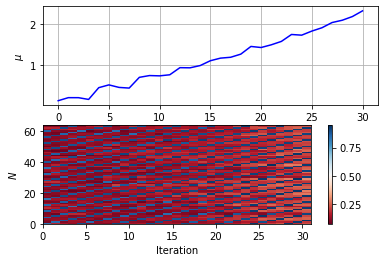

In [14]:
start = time.time()

nloop = int(10**wloop)

ch = CH(M_, N_, K,rho)
mod = MOD(ml)
model = TGaBP(2*M_, 2*N_, mod, Niter)
opt   = optim.Adam(model.parameters(), lr=adam_lr)
loss_func = nn.MSELoss()

N0 = 10.0 ** (-EsN0 / 10.0)
for idx_loop in range(0, nloop):
    ch.fading_gen()
    b, x, y, H = gen_minibatch(ch, mod, N0)
    opt.zero_grad()
    x_hat = model(x, y, H, N0, mod, Niter)
    loss  = loss_func(x_hat, x)
    loss.backward()  # 誤差逆伝播法(後ろ向き計算の実行)
    opt.step()       # 学習可能パラメータの更新
    if((idx_loop%10)==0):
        print(idx_loop, loss.item())

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

# mu
plt.subplot(2,1,1)
plt.grid()
plt.plot(model.mu[:-1].detach().numpy(), color="blue")
plt.xlabel('Iteration')
plt.ylabel(r'$\mu$')

# eta
plt.subplot(2,1,2)
c =plt.pcolor(model.sigmoid(model.eta[:,:-1]).detach().numpy(), cmap='RdBu')
plt.xlabel('Iteration')
plt.ylabel(r'$N$')
plt.colorbar(c)



## 試験フェーズ

In [13]:
noe   = np.zeros(2,dtype = int)

with torch.no_grad():
    for idx_loop in range (0, nloop):
        # Fading generation
        ch.fading_gen()
        b, x, y, H = gen_minibatch(ch, mod, N0)
        x_ = model(x, y, H, N0, mod, Niter)
        b_ = mod.demodulation((x_[:, :M_] + 1j * x_[:, M_:]))

        tmp = (b_!=b).sum(axis=1)
        noe[0] += tmp.sum()
        noe[1] += (mod.ml*ch.M_*ch.K)

BER = noe[0]/noe[1]

print('Es/N0= %d [dB] -> BER= %e' % (EsN0,BER) )

NameError: name 'mod' is not defined

In [14]:
c =plt.pcolor(model.sigmoid(model.eta[:,:-1]).detach().numpy(), cmap='jet')
plt.xlabel('Iteration')
plt.ylabel(r'$N$')
plt.colorbar(c)

NameError: name 'model' is not defined